In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as p
from pathlib import Path
import time
from sklearn.preprocessing import OneHotEncoder
import random
from IPython.display import Audio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
import torchvision.transforms.functional as fn
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Audio 
import torchaudio
from torchaudio.transforms import MelSpectrogram, Resample
import gc
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm

# Device Settings

## Metrics

In [68]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def map_score(solution, submission):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    score = sklearn.metrics.average_precision_score(
        solution,
        submission,
        average='micro',
    )
    return score

In [69]:
a = [[1,0,0],[1,0,0]]
b = [[0.8,0.1,0.1],[0.9,0.05,0.05]]
#b = [183, 123, 123, 135, 169, 123, 249, 135, 135, 135, 169, 123, 135, 123,
#        118,  31, 169, 135, 185,  73, 259, 169, 123, 135, 123, 183, 135, 169,
#        169,  84,  60,  62]
#a = [ 29, 170,  74,  20, 247,  74, 167, 123,  20,  89, 201,  20, 162, 123,
#        118,  77, 229, 183, 185,  73, 259, 174,  70, 135, 185,  20, 135,  71,
#        169, 219,  72, 162]
#map_score(a,b)
sklearn.metrics.label_ranking_average_precision_score(a,b)
map_score(a,b)

1.0

In [70]:
#!pip install timm
#!pip install --upgrade wandb
import timm

## Dataframes

In [71]:
train_metadata = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
eBird_taxonomy = pd.read_csv('/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv')
sample_submission = pd.read_csv('/kaggle/input/birdclef-2023/sample_submission.csv')

In [72]:
class CFG:
    seed = 42
    DEBUG = False
    train_root = '/kaggle/input/birdclef-2023/train_audio/'
    Trans = False
    file_path = 'filepath'
    label = 'primary_label'
    sample_rate  =  32000 # torch audio default
    max_time = 5 # must set to max
    window_size_frames = 5.0
    hop_size_frames = 5.0
    batch_size = 64
    normalize = True
    #Visualize = True
    num_classes = 264
    model = 'tf_efficientnet_b0_ns'
    #model = 'tf_efficientnet_b4_ns'
    pretrained = True
    use_mixup = False
    LR = 5e-4
    Visualize = False
    weight_decay = 1e-3
    PCA = True
    device = 'GPU'
if CFG.DEBUG:
    CFG.epochs = 10
else:
    CFG.epochs = 20

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

In [74]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    CFG.device = "TPU"
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
    CFG.device = "GPU"
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


# Metadata and dataframes exploration

In [75]:
eBird_taxonomy

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN
...,...,...,...,...,...,...,...,...,...
16748,34694,species,slcgro1,Slate-colored Grosbeak,Saltator grossus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16749,34697,species,bltgro2,Black-throated Grosbeak,Saltator fuliginosus,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16750,34698,spuh,saltat1,saltator sp.,Saltator sp.,Passeriformes,Thraupidae (Tanagers and Allies),NaN,NaN
16751,34699,spuh,passer1,passerine sp.,Passeriformes sp.,Passeriformes,NaN,Others,NaN


In [76]:
sample_submission

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
train_metadata = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')

In [78]:
# Acho que vou cagar na metadata,não a temos para forecast por isso....
del train_metadata['scientific_name']
del train_metadata['author']
del train_metadata['common_name']
del train_metadata['license']
del train_metadata['url']
del train_metadata['type']
del train_metadata['secondary_labels']

if CFG.device == "TPU":
    train_metadata['filepath'] = GCS_PATH + train_metadata['filename']
else:
    train_metadata['filepath'] = CFG.train_root + train_metadata['filename']
train_metadata

,primary_label,latitude,longitude,rating,filename,filepath
0,abethr1,4.3906,38.2788,4.0,abethr1/XC128013.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...
1,abethr1,-2.9524,38.2921,3.5,abethr1/XC363501.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...
2,abethr1,-2.9524,38.2921,3.5,abethr1/XC363502.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...
3,abethr1,-2.9524,38.2921,5.0,abethr1/XC363503.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...
4,abethr1,-2.9524,38.2921,4.5,abethr1/XC363504.ogg,/kaggle/input/birdclef-2023/train_audio/abethr...
...,...,...,...,...,...,...
16936,yewgre1,-1.2502,29.7971,3.0,yewgre1/XC703472.ogg,/kaggle/input/birdclef-2023/train_audio/yewgre...
16937,yewgre1,-1.2489,29.7923,4.0,yewgre1/XC703485.ogg,/kaggle/input/birdclef-2023/train_audio/yewgre...
16938,yewgre1,-1.2433,29.7844,4.0,yewgre1/XC704433.ogg,/kaggle/input/birdclef-2023/train_audio/yewgre...
16939,yewgre1,0.0452,36.3699,4.0,yewgre1/XC752974.ogg,/kaggle/input/birdclef-2023/train_audio/yewgre...


In [79]:
test = '/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg'
samples, sample_rate = librosa.load(test)
samples.shape, sample_rate

((13230000,), 22050)

In [80]:
audio, sample_rate = torchaudio.load(test)
audio.shape, sample_rate

(torch.Size([1, 19200000]), 32000)

In [81]:
classes = train_metadata.groupby('primary_label')['filepath'].count()
len(classes)

264

In [82]:
classes['crefra2']

1

In [83]:
a = train_metadata['primary_label'].unique()
len(a)

264

In [84]:
for b in a:
    if b.startswith("whc"):
        print(b, classes[b])

whcpri2 9
whctur2 1


In [85]:
CFG.num_classes = len(classes)
CFG.num_classes

264

<AxesSubplot:ylabel='Frequency'>

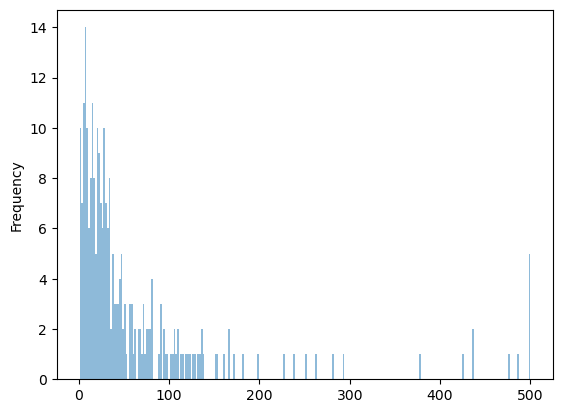

In [86]:
classes.plot.hist(bins=len(classes), alpha=0.5)

# Vamos ajustar os dados das classes excluindo as amostras excessivas e metendo-as no val_df. Isto significa que o val_df não será incrível, mas ao menos treinamos com os dados todos.

In [87]:
val_df = pd.DataFrame(columns = train_metadata.columns)
val_df

,primary_label,latitude,longitude,rating,filename,filepath


In [88]:
percentile = int(np.percentile(classes,40))
percentile

22

In [89]:
print(len(train_metadata),len(val_df))

16941 0


In [90]:
%%time
count = 0
lista = []
for index, row in train_metadata.iterrows():
        current_class = row['primary_label']
        if classes[current_class] > 5:
            prob_of_going_to_val = 0.15#classes[current_class]/(classes.mean() * 10)
        else:
            prob_of_going_to_val = 0.0
        if(random.random() <= prob_of_going_to_val):
            val_df.loc[count] = row
            train_metadata = train_metadata.drop(labels=index, axis=0)
            count += 1
print(len(train_metadata),len(val_df))

14432 2509
CPU times: user 13.7 s, sys: 13.6 ms, total: 13.7 s
Wall time: 13.7 s


# Upsample the train data only

In [91]:
classes

primary_label
abethr1     15
abhori1    126
abythr1     28
afbfly1     18
afdfly1     31
          ... 
yertin1    134
yesbar1     29
yespet1     15
yetgre1     27
yewgre1    108
Name: filepath, Length: 264, dtype: int64

In [92]:
%%time
# Upsample the lower classes to at least 20 samples
Upsampled = False
lista_upsampled = []
while(Upsampled == False):
    Upsampled = True
    for index,row in train_metadata.iterrows():
        #print(row)
        if(classes[row['primary_label']] <= 20):
            if(row['primary_label'] not in lista_upsampled):
                lista_upsampled.append(row['primary_label'])
                
            #print(len(train_metadata),' a')
            #train_metadata.loc[len(train_metadata)-1] += row
            train_metadata = train_metadata.append(row, ignore_index=True)

            #print(len(train_metadata),' b')
            Upsampled = False
            classes = train_metadata.groupby('primary_label')['filepath'].count()
            #print(classes[row['primary_label']],row['primary_label'],len(train_metadata))

CPU times: user 15.4 s, sys: 18.5 ms, total: 15.4 s
Wall time: 15.6 s


<AxesSubplot:ylabel='Frequency'>

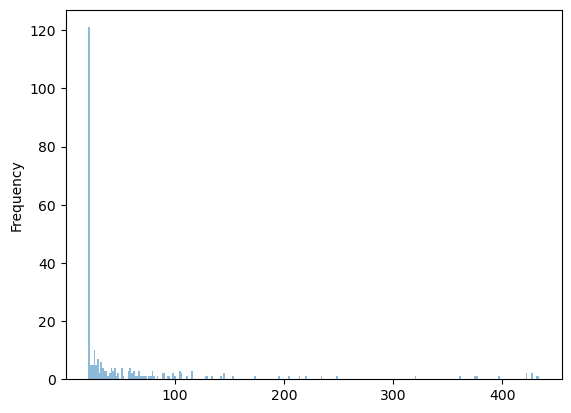

In [93]:
classes.plot.hist(bins=len(classes), alpha=0.5)

### Shuffle Dataframes

In [94]:
train_metadata = train_metadata.sample(frac=1).reset_index()
val_df = val_df.sample(frac=1).reset_index()

In [95]:
val_classes = val_df.groupby('primary_label')['filepath'].count()
len(val_classes)

229

In [96]:
print(f'We are missing {len(classes)  - len(val_classes)}  classes in the validation df so results may be biased')

We are missing 35  classes in the validation df so results may be biased


# Pytorch DataLoaders

In [97]:
encoder = LabelEncoder()
CFG.label_encoder = encoder.fit(train_metadata['primary_label'])

In [98]:
train_metadata['label'] = CFG.label_encoder.transform(train_metadata['primary_label'])
val_df['label'] = CFG.label_encoder.transform(val_df['primary_label'])

In [99]:
train_metadata.head()

,index,primary_label,latitude,longitude,rating,filename,filepath,label
0,6953,grewoo2,-17.8070,25.6894,4.5,grewoo2/XC125568.ogg,/kaggle/input/birdclef-2023/train_audio/grewoo...,107
1,8604,litswi1,-24.3931,31.7782,4.0,litswi1/XC731944.ogg,/kaggle/input/birdclef-2023/train_audio/litswi...,136
2,3211,cohmar1,47.9963,10.9543,4.5,cohmar1/XC417422.ogg,/kaggle/input/birdclef-2023/train_audio/cohmar...,70
3,5161,eaywag1,47.5090,9.6561,3.0,eaywag1/XC648009.ogg,/kaggle/input/birdclef-2023/train_audio/eaywag...,84
4,1143,barswa,53.9299,-2.9833,2.5,barswa/XC702809.ogg,/kaggle/input/birdclef-2023/train_audio/barswa...,20


In [100]:
len(train_metadata.label.unique()),len(val_df.label.unique())

(264, 229)

In [101]:
label_encoder = OneHotEncoder(sparse = False) 
CFG.label_encoder = label_encoder.fit(train_metadata['primary_label'].unique().reshape(-1,1))

In [102]:
CFG.label_encode = 'One_hot'
#CFG.label_encode = 'Not_One_hot'

In [103]:
from scipy.ndimage import gaussian_filter

In [104]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

In [105]:
def seg(samples):
    
    fft = torch.fft.fft(samples)
    Power_spectrum = fft*torch.conj(fft)/len(samples)
    a = torch.real(Power_spectrum)
    indx = a > torch.max(a)/250
    fft_clean = fft*indx
    clean = torch.fft.ifft(fft_clean)
    clean = torch.real(clean)
    
    #clean = gaussian_filter(samples, sigma = 1.7)
    return torch.tensor(clean)
#CFG.Trans = seg

In [106]:
import pywt
def vis_wavelet_denoising(audio_signal, level = 6):
    
    wavelet = 'db4'
    mode = pywt.Modes.smooth

    coeffs = pywt.wavedec(audio, wavelet, mode=mode, level=level)

    # Definir o threshold para cada coeficiente
    threshold = 0.5 * np.median(np.abs(coeffs[-level]))

    # Aplicar o threshold em cada coeficiente
    for i in range(-level, 0):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Reconstituir o sinal de áudio denoised
    denoised_audio = pywt.waverec(coeffs, wavelet, mode=mode)
    
    
    #boole = False
    #na = np.count_nonzero(np.isnan(denoised_audio))
    #if na > 0 :
    #    print(na,denoised_audio.shape)
     #   boole = True
    denoised_audio[np.isinf(denoised_audio)] = 0.0001
    denoised_audio = np.nan_to_num(denoised_audio, nan=0.0001)
        #denoised_signal += 0.00000001
    
    return denoised_audio



In [107]:
def plot_dif(denoised_signal,audio_signal):
    n_mels = 64
    n_fft = 1024
    hop_len=None
    top_db = 80
    
    denoised_signal = torch.tensor(denoised_signal)
    denoised_signal = torchaudio.transforms.MelSpectrogram(CFG.sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(denoised_signal)
    denoised_signal = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(denoised_signal)
        
    audio_signal = torch.tensor(audio_signal)
    audio_signal = torchaudio.transforms.MelSpectrogram(CFG.sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(audio_signal)
    audio_signal = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(audio_signal)
    
    plt.figure(figsize=(14, 5))        
    librosa.display.specshow(np.array(denoised_signal.clone().detach()), sr=32000, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Denoised (dB)')


    plt.figure(figsize=(14, 5))
    librosa.display.specshow(np.array(audio_signal), sr=CFG.sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original (dB)')


In [108]:
import pywt

def wavelet_lowpass_filter(audio_signal, wavelet_name='db4', level=5):
    """Apply wavelet-based low-pass filter to an audio signal
    
    Parameters:
    audio_signal (array): Noisy audio signal
    wavelet_name (str): Name of the wavelet to use (default 'db4')
    level (int): Number of decomposition levels (default 5)
    
    Returns:
    array: Filtered audio signal
    """
    # Decompose the signal using the specified wavelet and number of levels
    coeffs = pywt.wavedec(audio_signal, wavelet_name, level=level)
    
    # Keep only the approximation coefficients at the highest level of the decomposition
    coeffs[0] = None
    
    # Reconstruct the signal from the modified wavelet coefficients
    filtered_signal = pywt.waverec(coeffs, wavelet_name)
    
    return filtered_signal


In [109]:
CFG.low_pass_filter = True
CFG.Trans = vis_wavelet_denoising

In [110]:
import torchvision

In [111]:
class Create_Visualization_Dataset(Dataset):
    
    def __init__(self, df, source_column = CFG.file_path,
                 transform = CFG.Trans, max_time = CFG.max_time,target_column = CFG.label,
                  sample_rate = CFG.sample_rate):
        self.df = df
        self.transform = transform
        self.source_audio = self.df[source_column]
        self.sample_rate = sample_rate
        self.audio_length = int(max_time*sample_rate) 
        if(CFG.label_encode != 'One_hot'):
            self.target_classes = self.df['label']
        else:
            self.target_classes = self.df[target_column]
        
    def __len__(self):
        return len(self.df)
    
    def spectro_gram(self,sr ,aud, n_mels = 64, n_fft = 1024, hop_len=None):
        sig = aud
        
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        #
        print("Original Spec shape :",spec.shape)
        return (spec)
    
    
    def pad_audio(self, audio):
        pad_length = self.audio_length - audio.shape[0]
        last_dim_padding = (0, pad_length)
        audio = F.pad(audio, last_dim_padding)
        return audio
        
    
    def crop_spec(self, image):
        
        length = image.shape[1]
        rand = random.randint(0,length)
        #print(image.shape)

        #image = image[:,start:end]
        
        
        if(rand + 313 < length):
            if CFG.Visualize:
                print('a')
            return image[:,rand : rand + 313] 
        elif(rand + 313 > length):
            if CFG.Visualize:    
                print('b')
            return image[:,rand - 313: rand] 
        else:
            if CFG.Visualize:
                print('c')
            return image[:,:313]
    
    def crop_audio(self, audio):
        rand = random.randint(0,len(audio))
        if(rand + self.audio_length < len(audio)):
            if CFG.Visualize:
                print('a')
            return audio[rand: rand + self.audio_length]
        elif(rand - self.audio_length > 0):
            if CFG.Visualize:    
                print('b')
            return audio[ rand - self.audio_length : rand]
        else:
            if CFG.Visualize:
                print('c')
            return audio[: self.audio_length]
    def to_mono(self, audio):
        return torch.mean(audio, axis=0)
    
    def normalize(self,image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image
    
    def __getitem__(self, index):
        source_audio = self.source_audio[index]
        target_classes = self.target_classes[index]
        
        audio, sample_rate = torchaudio.load(source_audio)
        
        audio = self.to_mono(audio)
        if sample_rate != self.sample_rate:
            resample = Resample(sample_rate, self.sample_rate)
            audio = resample(audio)

        if audio.shape[0] < self.audio_length:
            audio = self.pad_audio(audio)    
            
        
        #print("original shape  ",audio.shape)
        
        if CFG.PCA == True:
            #print(audio.shape)
            if audio.shape[0] >= 3*(self.audio_length):
                print("We have PCA")
                audio_1 = audio[:(int(np.ceil(audio.shape[0] / (5*32000)))-1)*5*32000]
                samples_2 = np.array_split(audio_1, int(np.ceil(audio_1.shape[0] / (5*32000))),axis = 0)
                yo = np.stack( samples_2, axis=1)
                audio = pca.fit_transform(yo).squeeze()
                audio = torch.tensor(pca.fit_transform(yo).squeeze())
                #print(audio.shape)
        
        if CFG.low_pass_filter == True:
            print("Low Pass")
            audio_3 = wavelet_lowpass_filter(audio)
            audio = torch.tensor(audio_3)
            #gausian_2 = self.spectro_gram(sr = self.sample_rate,aud = audio_3)
            #print("Tipo do trans : ",gausian_2.shape, type(gausian_2)) 
        if CFG.Trans != None:
            print("Entreii")
            audio = nr.reduce_noise(y=audio, sr=CFG.sample_rate)
            #audio = CFG.Trans(audio.cpu().detach().numpy())
            audio = torch.tensor(audio)
        
        if audio.shape[0] > self.audio_length:
            audio = self.crop_audio(audio)
        
        original = self.spectro_gram(sr = self.sample_rate,aud = audio[:160000])
            
        if  CFG.pseudo_PCA == True:
                yo = audio[:32000]+audio[32000:64000]+audio[64000:96000]+audio[96000:128000]+audio[128000:160000]
                yo = yo.cpu().detach().numpy()
                #print(yo.shape)
                yo = np.append(yo,[yo,yo,yo,yo])
                #print("a ",type(yo))
                audio = torch.tensor(yo)
        
        
        
            
        
        
        
        
        audio = self.spectro_gram(sr = self.sample_rate,aud = audio)
        
        #image = self.normalize(audio)
        resized = fn.resize(audio[None,:,:], size=[224,224],interpolation  = torchvision.transforms.InterpolationMode.BICUBIC)[0]


        if CFG.IMG_Trans is not None:
            image = train_augs(image=resized.cpu().detach().numpy())['image'][0]#.mT

        image = torch.stack([image, image, image])
        
        return original.clone().detach() , image.clone().detach() ,resized.clone().detach()
        
        

In [112]:
class Create_Dataset(Dataset):
    '''
    df : dataframe
    source_column : the column with the text
    target_column : Column with the target
    transform : for possible augmentations
    freq_threshold: minimum amount of times a word needs to be appear in the corpus to be considered for vocab
    '''
    
    def __init__(self, df,validation = False,label_encoder = CFG.label_encoder, source_column = CFG.file_path, target_column = CFG.label,
                 transform = CFG.Trans, max_time = CFG.max_time,
                  sample_rate = CFG.sample_rate):
        
        self.df = df
        self.transform = transform
        self.source_audio = self.df[source_column]
        if(CFG.label_encode != 'One_hot'):
            self.target_classes = self.df['label']
        else:
            self.target_classes = self.df[target_column]
        self.classes = len(self.target_classes.unique())
        self.sample_rate = sample_rate
        self.audio_length = int(max_time*sample_rate) 
        self.validation = validation
        # LabelEncoding
        self.label_encoder = label_encoder
        
        
    def __len__(self):
        return len(self.df)
    
    #@staticmethod
    def normalize(self,image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image
    
    # Isto vai-te buscar automaticamente uma linha do df e transforma-a em tokens + target
    # não precisas de inicializar, podes apenas chamar o objecto e ver o seu índice
    
    def __getitem__(self, index):
        source_audio = self.source_audio[index]
        target_classes = self.target_classes[index]
        
        audio, sample_rate = torchaudio.load(source_audio)
        
        
        
        # o pytorch devolve as dimensoes como (1,audio_length)
        # a linha abaixo remove a primeira dim
        audio = self.to_mono(audio)
        
        #if self.validation == False and CFG.PCA == True:
             #if audio.shape[0] >= 3*(self.audio_length):
                #print("We have PCA")
                #audio_1 = audio[:(int(np.ceil(audio.shape[0] / (5*32000)))-1)*5*32000]
                #samples_2 = np.array_split(audio_1, int(np.ceil(audio_1.shape[0] / (5*32000))),axis = 0)
                #yo = np.stack(samples_2, axis=1)
                #audio = pca.fit_transform(yo).squeeze()
                #audio = torch.tensor(pca.fit_transform(yo).squeeze())
                #print(audio.shape)
                #if audio.shape[0] >= (self.audio_length):
                #print("PCA Aconteceu")
                #print("Original ",audio.shape)
                #   audio_1 = audio[:(int(np.ceil(audio.shape[0] / (32000)))-1)*32000]
                #print("plus 1 ",audio_1.shape)
                #  samples_2 = np.array_split(audio_1, int(np.ceil(audio_1.shape[0] / (32000))),axis = 0)
                #  yo = np.stack( samples_2, axis=1)
                #audio = torch.tensor(pca.fit_transform(yo).squeeze())
                #  audio = torch.tensor(np.repeat(pca.fit_transform(yo).squeeze(),5))
                #print("final ",audio.shape)
                
        if sample_rate != self.sample_rate:
            resample = Resample(sample_rate, self.sample_rate)
            audio = resample(audio)  
             
        if audio.shape[0] < self.audio_length:
            audio = self.pad_audio(audio)
        
        
        
        if audio.shape[0] > self.audio_length:
            audio = self.crop_audio(audio)
        
        if CFG.low_pass_filter == True:
            audio = wavelet_lowpass_filter(audio)
            audio = torch.tensor(audio)
        
        
        if CFG.Trans != None:
            audio = nr.reduce_noise(y=audio, sr=CFG.sample_rate)
            #audio = CFG.Trans(audio.cpu().detach().numpy())
            audio = torch.tensor(audio)
        
        
        if CFG.PCA == True:
            samples_2 = np.array_split(audio, int(np.ceil(audio.shape[0] / (32000))),axis = 0)
            yo = np.stack(samples_2, axis=1)
            yo = pca.fit_transform(yo).squeeze()
            audio = torch.tensor(np.append(yo,[yo,yo,yo,yo]))
           
        
        if self.validation == True and CFG.PCA == True:
                samples_2 = np.array_split(audio, int(np.ceil(audio.shape[0] / (32000))),axis = 0)
                yo = np.stack( samples_2, axis=1)
                yo = pca.fit_transform(yo).squeeze()
                audio = torch.tensor(np.append(yo,[yo,yo,yo,yo]))
        
        if  CFG.pseudo_PCA == True:
                yo = audio[:32000]+audio[32000:64000]+audio[64000:96000]+audio[96000:128000]+audio[128000:160000]
                yo = yo.cpu().detach().numpy()
                #print(yo.shape)
                yo = np.append(yo,[yo,yo,yo,yo])
                #print("a ",type(yo))
                audio = torch.tensor(yo)
        
        
        # Label encoding
        if(CFG.label_encode != 'One_hot'):
            train_labels_encoded = target_classes
        else:
            train_labels_encoded = self.label_encoder.transform(np.array([target_classes]).reshape(-1, 1))
    
        
        audio = self.spectro_gram(sr = self.sample_rate,aud = audio)
        
        image = self.normalize(audio)
        #print(image.shape)
        image = fn.resize(image[None,:,:], size=[224,224],interpolation  = torchvision.transforms.InterpolationMode.BICUBIC)[0]

        #print(image.shape)
        if CFG.IMG_Trans is not None and self.validation == False:
            if(target_classes in lista_upsampled):
                image = train_augs_2(image=image.cpu().detach().numpy())['image'][0]#.mT
            else:
                image = train_augs(image=image.cpu().detach().numpy())['image'][0]#.mT
  
            
        #if CFG.IMG_Trans is not None and self.validation == True:
        #    image = valid_augs(image=image.cpu().detach().numpy())['image'][0]#.mT

            
        image = torch.stack([image, image, image])
        
        #meter para classes mais baixas
        #image = get_train_transform(image.unsqueeze(0)).squeeze()
        if(CFG.label_encode != 'One_hot'):
            return image,torch.tensor(train_labels_encoded)
        else:
            return image,torch.tensor(train_labels_encoded[0])#.requires_grad_(True)

    
    #@staticmethod
    def spectro_gram(self,sr ,aud, n_mels = 64, n_fft = 1024, hop_len=None):
        sig = aud
        
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        #print(spec.shape)
        return (spec)
    
    
    def pad_audio(self, audio):
        pad_length = self.audio_length - audio.shape[0]
        last_dim_padding = (0, pad_length)
        audio = F.pad(audio, last_dim_padding)
        return audio
        
    
    def crop_spec(self, image):
        
        length = image.shape[1]
        rand = random.randint(0,length)
 
        if(rand + 313 < length):
            #print('a')
            return image[:,rand : rand + 313] 
        elif(rand - 313 > 0):
            #print('b')
            return image[:,rand - 313: rand] 
        else:
            #print('c')
            return image[:,:313]
    
    def crop_audio(self, audio):
        rand = random.randint(0,len(audio))
        if(rand + self.audio_length < len(audio)):
            
            return audio[rand: rand + self.audio_length]
        elif(rand - self.audio_length > 0):
            
            return audio[ rand - self.audio_length : rand]
        else:
            
            return audio[: self.audio_length]
    def to_mono(self, audio):
        return torch.mean(audio, axis=0)
    
    
    def mono_to_color3(X, eps=1e-6, mean=None, std=None):
        """
        Converts a one channel array to a 3 channel one in [0, 255]
        Arguments:
            X {numpy array [H x W]} -- 2D array to convert
        Keyword Arguments:
            eps {float} -- To avoid dividing by 0 (default: {1e-6})
            mean {None or np array} -- Mean for normalization (default: {None})
            std {None or np array} -- Std for normalization (default: {None})
        Returns:
            numpy array [3 x H x W] -- RGB numpy array
        """
        #X = np.stack([X, X, X], axis=-1)

        # Standardize
        mean = mean or torch.mean(X)
        std = std or torch.std(X)
        X = (X - mean) / (std + eps)

        # Normalize to [0, 255]
        _min, _max = X.min(), X.max()
        
        if (_max - _min) > eps:
            V = np.clip(X, _min, _max)
            V = 255 * (V - _min) / (_max - _min)
            V = V.astype(np.uint8)
        else:
            V = np.zeros_like(X, dtype=np.uint8)

        return V


In [113]:
#print(audio.shape)
        #if CFG.IMG_Trans is not None:
        #    image = torch.stack([audio_5[0], audio_5[0], audio_5[0]])
        #else:
        #image = torch.stack([audio, audio, audio])
        
        #del audio
        
        #if CFG.IMG_Trans is None:
        #image = self.normalize(image)

In [114]:
def plot_random_spec_spectogram(dataGen):
    rand_numba = random.randint(0,len(dataGen))
    
    if CFG.Visualize:
        audio = dataGen[rand_numba][0]
        plt.figure(figsize=(14, 5))
        
        librosa.display.specshow(np.array(audio), sr=CFG.sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Original Spectrogram (dB)')
        
        gaussian_audio = dataGen[rand_numba][1]
        #spectrogram = librosa.stft(np.array(gaussian_audio))
        #spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
        plt.figure(figsize=(14, 5))
        print("Shapes : ",np.array(audio).shape, gaussian_audio[0].shape)
        librosa.display.specshow(gaussian_audio[0].cpu().detach().numpy(), sr=CFG.sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Transformed  Spectrogram (dB)')
        #print(dataGen[rand_numba][2])
        
        original_audio = dataGen[rand_numba][2]
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(np.array(original_audio), sr=CFG.sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Resized Original Spectrogram (dB)')
        #print(dataGen[rand_numba][2])
        
        #cacaca = dataGen[rand_numba][3]
        #plt.figure(figsize=(14, 5))
        #librosa.display.specshow(np.array(cacaca), sr=CFG.sample_rate, x_axis='time', y_axis='log')
        #plt.colorbar(format='%+2.0f dB')
        #plt.title('Gausian Spectrogram Partially made (dB)')
    
    else:
        audio = dataGen[rand_numba][0][0]
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(np.array(audio), sr=CFG.sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (dB)')

In [115]:
from albumentations.pytorch import ToTensorV2
mean2 = (0.5, 0.5, 0.5) # RGB
std2 = (0.5, 0.5, 0.5) #RGB
mean = (0.5) # R only for RGB
std = (0.5) # R only for RGB

train_augs_2 =  A.Compose([
    
    #A.Normalize(mean, std,p=1.0),
    A.HorizontalFlip(p=0.6),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5,p=0.8),

    ToTensorV2(p = 1),
],p= 1)

train_augs = A.Compose([
    #A.RandomResizedCrop(height=64, width=313,interpolation=Image.BICUBIC, p=1.0),
    #A.Normalize(mean, std,p=1.0),
    A.HorizontalFlip(p=0.1),
    A.VerticalFlip(p=0),
    #A.RandomBrightnessContrast(p=1),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5,p=0.1),
    #A.OneOf([
                #A.Cutout(max_h_size=5, max_w_size=16),
    #            A.CoarseDropout(max_holes=4),
    #        ], p=1),
    #A.SmallestMaxSize(max_size=160,p = 1),
    #A.RandomCrop(height=224, width=224),
    #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    ToTensorV2(p = 1),
], p = 1)

valid_augs = A.Compose([

    #        A.Normalize(mean, std, p = 1),
    ToTensorV2(),
], p = 1)

In [116]:
! pip install noisereduce -qq

In [117]:
pip show noisereduce

Name: noisereduce
Version: 2.0.1
Summary: Noise reduction using Spectral Gating in python
Home-page: https://github.com/timsainb/noisereduce
Author: Tim Sainburg
Author-email: 
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: librosa, matplotlib, numpy, scipy, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [118]:
import noisereduce as nr

In [119]:
CFG.Visualize = True
CFG.Trans = "Noise_reducer"

CFG.PCA = False
CFG.low_pass_filter = True
#CFG.Trans = wave_denoise
CFG.pseudo_PCA = False

CFG.IMG_Trans = train_augs

In [120]:
vis_train = Create_Visualization_Dataset(df = train_metadata)
train = Create_Dataset(df = train_metadata, validation = False)
val = Create_Dataset(df = val_df)
a,b = train[1], train[1]
#train[1][0]

In [121]:
torch.std(a[0][0]),torch.mean(a[0][0]), a[0][0].shape

(tensor(0.0643), tensor(-0.1817), torch.Size([224, 224]))

In [122]:
train[0][0].shape

torch.Size([3, 224, 224])

In [123]:
"""def wave_denoise(audio, level = 5):
    #wavelet = 'db4'
    wavelet = 'bior2.8'
    mode = pywt.Modes.smooth
    

    # Definir o nível de decomposição


    # Realizar a decomposição wavelet
    coeffs = pywt.wavedec(audio, wavelet, mode=mode, level=level)

    # Definir o threshold para cada coeficiente
    threshold = 0.5 * np.median(np.abs(coeffs[-level]))

    # Aplicar o threshold em cada coeficiente
    for i in range(-level, 0):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Reconstituir o sinal de áudio denoised
    denoised_audio = pywt.waverec(coeffs, wavelet, mode=mode)
    
    denoised_audio[np.isinf(denoised_audio)] = 0.0001
    denoised_audio = np.nan_to_num(denoised_audio, nan=0.0001)
    
    return denoised_audio"""

def wave_denoise(audio, level = 5):
    wavelet = 'bior2.8'
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    
    # Apply thresholding to the detail coefficients
    thresholded_coeffs = []
    threshold_mode='hard'

    noise_std = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = 10 * noise_std
    for i in range(1, len(coeffs)):
        thresholded_coeffs.append(pywt.threshold(coeffs[i], threshold, mode=threshold_mode))
    
    # Reconstruct the denoised signal
    denoised_signal = pywt.waverec([coeffs[0]] + thresholded_coeffs, wavelet)
    
    return denoised_signal
CFG.Trans = wave_denoise

Low Pass
Entreii
a
Original Spec shape : torch.Size([64, 313])
Original Spec shape : torch.Size([64, 313])
Low Pass
Entreii
a
Original Spec shape : torch.Size([64, 313])
Original Spec shape : torch.Size([64, 313])
Shapes :  (64, 313) torch.Size([224, 224])
Low Pass
Entreii
b
Original Spec shape : torch.Size([64, 313])
Original Spec shape : torch.Size([64, 313])


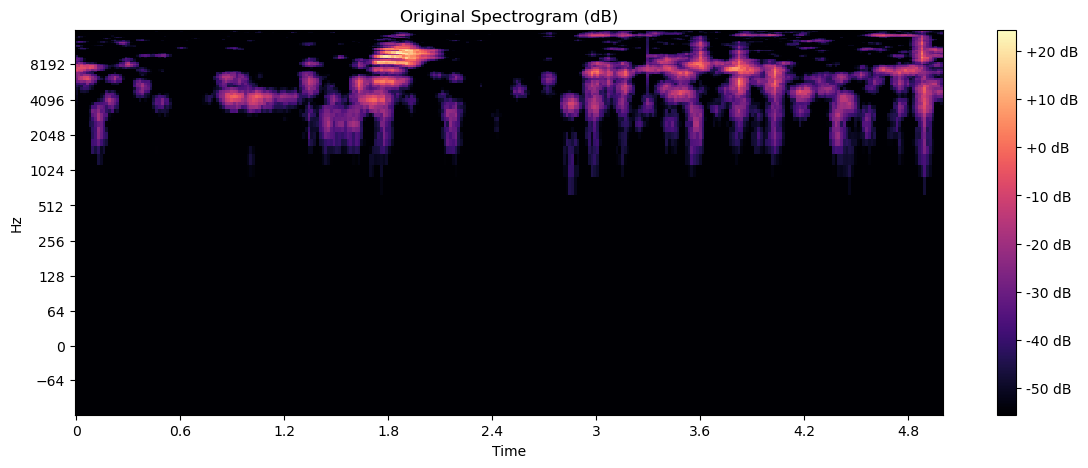

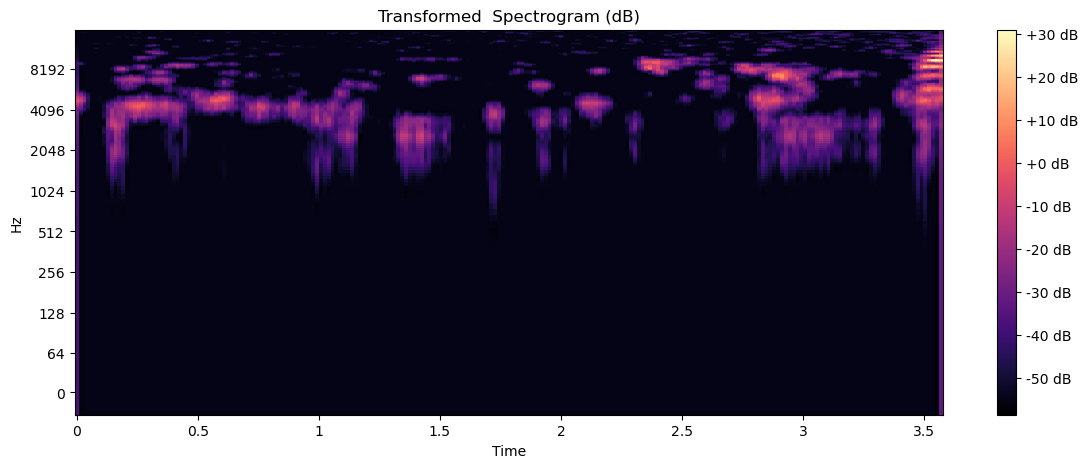

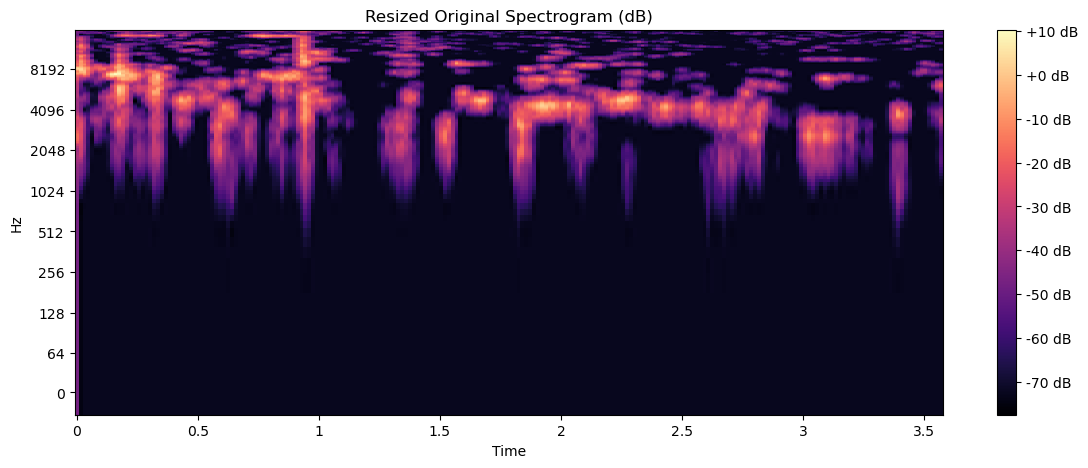

In [124]:
CFG.Visualize = True
CFG.Trans = None

CFG.IMG_Trans = train_augs
CFG.Trans = "Noise_reducer"
CFG.PCA = False
CFG.pseudo_PCA = False
CFG.low_pass_filter = True
plot_random_spec_spectogram(vis_train)

In [125]:
CFG.Visualize = False

## Torch Model

In [126]:
#!pip install --pre timm

In [127]:
timm.list_models("eff*")

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b0_g8_gn',
 'efficientnet_b0_g16_evos',
 'efficientnet_b0_gn',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_g8_gn',
 'efficientnet_b3_gn',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl']

In [128]:
model = timm.create_model("efficientnet_b0", pretrained=True)
model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [129]:
import torch
import torch.nn as nn
import timm
import torchvision
class ViTBase16(nn.Module):
    def __init__(self, model_name= CFG.model, num_classes = CFG.num_classes,
                 pretrained = CFG.pretrained):

        super(ViTBase16, self).__init__()

        
        self.model = timm.create_model("vit_base_patch16_224_in21k", pretrained=pretrained)
        #self.model = timm.create_model("efficientnet_b0", pretrained=pretrained)
        self.data_cfg = timm.data.resolve_data_config(self.model.pretrained_cfg)
        self.transform = timm.data.create_transform(**self.data_cfg)
        
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
        
    def forward(self, x):
        #x = torchvision.transforms.functional.to_pil_image(x, mode=None)
        #x = self.transform(x)
        x = self.model(x)
        return x


In [133]:
class Simple_Model(nn.Module):
    def __init__(self,model_name= CFG.model, num_classes = CFG.num_classes,
                 pretrained = CFG.pretrained):
        
        super(Simple_Model,self).__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model('efficientnet_b0', pretrained=pretrained)
        self.in_features = self.backbone.classifier.out_features
        #print('aa ',self.in_features)
        self.fc = nn.Linear(self.in_features, self.num_classes)
        # Em vez de criar mais um par de camadas vou só mudar a última camada do Timm model
        #self.backbone.reset_classifier(self.num_classes)
        
    def forward(self,images):
        features = self.backbone(images)
        #print(features.shape)
        output = self.fc(features)
        return output

In [131]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)
    #return nn.BCEWithLogitsLoss()(outputs,labels)
def train(model, data_loader, optimizer, scheduler, device, epoch, val_loss):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    print(f'Entered the training Loop')
    for i, (mels, labels) in enumerate(loop):
        #print(len(mels),mels[0].shape)
        mels = mels.to(device)
        labels = labels.to(device)
        #print(f'Managed to send {i}th data to device ')
        outputs = model(mels)
        del mels
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{CFG.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    i = 0
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        
        del mels
        loss = loss_fn(outputs, labels)            
        running_loss += loss.item()
        
        if i == 0:
            pred = outputs.cpu().detach().numpy()
            label = labels.cpu().detach().numpy()
        else: 
            np.append(pred,outputs.cpu().detach().numpy(),axis = 0)
            np.append(label,labels.cpu().detach().numpy(), axis = 0)
        loop.set_description(f"Epoch [{epoch+1}/{CFG.epochs}]")
        loop.set_postfix(loss=loss.item())
        del labels
    
        i += 1
    #return label,pred 
    avg_score3 = sklearn.metrics.label_ranking_average_precision_score(label,pred)
    valid_cmap = map_score(label, pred)
    return running_loss/len(data_loader), valid_cmap, avg_score3

In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTBase16().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


In [135]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=15)
#schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 2)

In [136]:
"""
lr_values = []
for epoch in range(15):
    lr_values.append(scheduler.get_last_lr()[0])
    optimizer.step()  # Perform optimization step
    scheduler.step()  # Update the scheduler

# Plotting the learning rate schedule
plt.plot(range(15), lr_values)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.show()"""

"\nlr_values = []\nfor epoch in range(15):\n    lr_values.append(scheduler.get_last_lr()[0])\n    optimizer.step()  # Perform optimization step\n    scheduler.step()  # Update the scheduler\n\n# Plotting the learning rate schedule\nplt.plot(range(15), lr_values)\nplt.xlabel('Epoch')\nplt.ylabel('Learning Rate')\nplt.title('Cosine Annealing Learning Rate Schedule')\nplt.show()"

In [137]:
device

device(type='cuda')

In [138]:
CFG.batch_size = 32

In [139]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)

In [140]:
def get_DataLoaders(train_ds,val_ds, batch_size = CFG.batch_size, num_workers = 2,
                   shuffle = True, pin_memory = False):
    train = Create_Dataset(df = train_ds, validation = False)
    validation = Create_Dataset(df = val_ds,validation = True)
    
    
    train_loader = DataLoader(train, batch_size = batch_size, num_workers = num_workers,worker_init_fn = worker_init_fn,
                             shuffle = shuffle, pin_memory = pin_memory)
    val_loader = DataLoader(validation, batch_size = batch_size, num_workers = num_workers,worker_init_fn = worker_init_fn,
                             shuffle = shuffle, pin_memory = pin_memory)
    
    return train_loader, val_loader

In [141]:
CFG.Trans = None
#CFG.Trans = wave_denoise
CFG.Trans = "Noise_reducer"

CFG.IMG_Trans = train_augs
CFG.PCA = False
CFG.pseudo_PCA = False
CFG.low_pass_filter = False

In [142]:
# set seed for reproducibility
def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
CFG.seed = 42
set_seed(CFG.seed)


In [ ]:
best_valid_cmpa = 0
best_valid_avg = 0

for epoch in range(CFG.epochs):
    if epoch == 0:
        valid_loss = 10
        
    dl_train, dl_val = get_DataLoaders(train_metadata, val_df)
    train_loss = train(model, dl_train, optimizer,scheduler, device, epoch,valid_loss)
    valid_loss, valid_cmpa, valid_avg_score = valid(model, dl_val, device, epoch)
    #if valid_avg_score > best_valid_avg:
    print(f"Validation CMAP Improved - {best_valid_cmpa} ---> {valid_cmpa}")
    print(f"Validation average_precision SCORE Improved - {best_valid_avg} ---> {valid_avg_score}")
    torch.save(model.state_dict(), f'./model_vit_low{epoch}_.bin')
    print(f"Saved model checkpoint at ./model_vit_low.bin")
    best_valid_cmpa = valid_cmpa
    best_valid_avg = valid_avg_score
    set_seed(CFG.seed + epoch)
torch.cuda.empty_cache()

  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [1/20]: 100%|██████████| 79/79 [02:04<00:00,  1.57s/it, loss=4.25]


Validation CMAP Improved - 0 ---> 0.18115879690333775
Validation average_precision SCORE Improved - 0 ---> 0.27227582051031307
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [2/20]: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it, loss=3.08]


Validation CMAP Improved - 0.18115879690333775 ---> 0.24410594522704662
Validation average_precision SCORE Improved - 0.27227582051031307 ---> 0.46702632341117223
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [3/20]: 100%|██████████| 79/79 [01:52<00:00,  1.42s/it, loss=2.65]


Validation CMAP Improved - 0.24410594522704662 ---> 0.4531522450131419
Validation average_precision SCORE Improved - 0.46702632341117223 ---> 0.6737051949634186
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [4/20]: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it, loss=2.56]


Validation CMAP Improved - 0.4531522450131419 ---> 0.4437753598601863
Validation average_precision SCORE Improved - 0.6737051949634186 ---> 0.6182795623359834
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [5/20]: 100%|██████████| 79/79 [01:54<00:00,  1.45s/it, loss=2.08]


Validation CMAP Improved - 0.4437753598601863 ---> 0.435218722206873
Validation average_precision SCORE Improved - 0.6182795623359834 ---> 0.5657102934101437
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [6/20]: 100%|██████████| 79/79 [01:53<00:00,  1.44s/it, loss=2.4] 


Validation CMAP Improved - 0.435218722206873 ---> 0.5153185069099172
Validation average_precision SCORE Improved - 0.5657102934101437 ---> 0.6507617172238238
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [7/20]: 100%|██████████| 79/79 [01:53<00:00,  1.43s/it, loss=2.05]


Validation CMAP Improved - 0.5153185069099172 ---> 0.46670469179737195
Validation average_precision SCORE Improved - 0.6507617172238238 ---> 0.6612577651176099
Saved model checkpoint at ./model_vit_low.bin


  0%|          | 0/488 [00:00<?, ?it/s]

Entered the training Loop


Epoch [8/20]:   4%|▍         | 21/488 [00:34<10:29,  1.35s/it, loss=1.72]

In [ ]:
import gc

In [ ]:
_ = gc.collect()

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

In [ ]:
def check_gradcam(self, dataloader, target_layer, target_category, reshape_transform=None):
        cam = GradCAMPlusPlus(
            model=self,
            target_layer=target_layer, 
            use_cuda=self.cfg.trainer.gpus, 
            reshape_transform=reshape_transform)
        
        org_images, labels = iter(dataloader).next()
        cam.batch_size = len(org_images)
        images = self.transform['val'](org_images)
        images = images.to(self.device)
        logits = self.forward(images).squeeze(1)
        pred = logits.sigmoid().detach().cpu().numpy() * 100
        labels = labels.cpu().numpy()
        
        grayscale_cam = cam(input_tensor=images, target_category=target_category, eigen_smooth=True)
        org_images = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255.
        return org_images, grayscale_cam, pred, labels